<div style="text-align: left;">
<table style="width:100%; background-color:transparent;">
  <tr style="background-color:transparent;">
<img border="0" src="https://www.usinenouvelle.com/mediatheque/3/2/7/000624723_image_600x315.jpg" width="30%"> </td>
<img border="0" src="https://josephsteinberg.com/wp-content/uploads/2020/01/Facial-Recognition.png" width="40%"> </td>
  </tr>
</table> 
</div>
<center><h1> Face Recognition</h1></center>
<br>
<center> Nayel Bettache, Solène Cochennec </center>

## Table of Contents

0. [Introduction](#intro)<br>
1. [Data Analysis](#Data-Analysis) <br>

<a id='intro'></a>
# <center> Introduction </center>

The aim of the project is to implement various techniques on face recognition, based on two articles "Face Recogniftion by Sparse Representation" (article 1) and "Robust Face Recognition via Sparse Representation" (article 2).



We will firstly select a face database (we only consider a small one for now, and we may extend it after). We will use the Yale face database (http://vision.ucsd.edu/content/yale-face-database) which contains 165 grayscale images in GIF format of 15 individuals. 

There are 11 images per subject, one per different facial expression or configuration: center-light, w/glasses, happy, left-light, w/no glasses, normal, right-light, sad, sleepy, surprised, and wink.

## Import the needed libraries

In [1]:
# File treatment libs

import zipfile
import shutil
from glob import glob
import os 
import sys
from os import listdir
from os.path import isfile, join

# Usual libs

from math import *
import time
import numpy as np
from numpy import linalg as lg
from numpy.fft import fft2
import pandas as pd 
import random
from random import shuffle
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import seaborn as sn


# Computer Vision libs

from PIL import Image
import cv2

# ML libs

import dlib
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
import l1ls as L

# Download data

### Import data via the py file

In [2]:
!python import_data.py

### Unzip and store data properly

In [3]:
# Verify you are working on the right directory

path = os.getcwd()
print("The path in wich we are working is %s " % path)

# If the needed directory already exist, remove it before recreate it

if os.path.exists(path + '/data/yalefaces'):
    shutil.rmtree(path + '/data/yalefaces')

# Unzip the data

path_zip = path + "/data/face_yale.zip"
directory = "data"
with zipfile.ZipFile(path_zip, 'r') as zip_ref:
    zip_ref.extractall(directory)

# Get the proper name of each image

collection = path + "/data/yalefaces"
for filename in os.listdir(collection):
    new_name = filename.replace(".","_")
    os.rename(path + "/data/yalefaces/" + str(filename), path + "/data/yalefaces/" + new_name + ".png")
os.remove(path + '/data/yalefaces/Readme_txt.png')

# Create subfolders for each subject 

for i in range(1, 16):
    if i < 10:
        nb_subj = '0' + str(i)
    else:
        nb_subj = str(i)
    path_dir = 'subject' + nb_subj
    #print('Executing the directory %s' %path_dir )
    try:
        os.mkdir(collection + '/' + path_dir)
    except OSError:
        print ("Creation of the directory %s failed" % path_dir)
    else:
        print ("Successfully created the directory %s " % path_dir)
    files_dir = [f for f in os.listdir(collection) if os.path.isfile(os.path.join(collection, f)) and 
             path_dir in f]
    for name in files_dir:
        shutil.move(collection + '/' + name, collection + '/' + path_dir)

The path in wich we are working is /Users/nbettache/Desktop/face_recognition 
Successfully created the directory subject01 
Successfully created the directory subject02 
Successfully created the directory subject03 
Successfully created the directory subject04 
Successfully created the directory subject05 
Successfully created the directory subject06 
Successfully created the directory subject07 
Successfully created the directory subject08 
Successfully created the directory subject09 
Successfully created the directory subject10 
Successfully created the directory subject11 
Successfully created the directory subject12 
Successfully created the directory subject13 
Successfully created the directory subject14 
Successfully created the directory subject15 


### Explore data

In [4]:
for i in range(1, 16):
    if i < 10:
        nb_subj = '0' + str(i)
    else:
        nb_subj = str(i)
    path_dir = 'subject' + nb_subj
    files = os.listdir(collection + '/' + path_dir)
    print('For the subject ' + str(i) + ' there are ' + str(len(files)) + ' pictures')

For the subject 1 there are 12 pictures
For the subject 2 there are 11 pictures
For the subject 3 there are 11 pictures
For the subject 4 there are 11 pictures
For the subject 5 there are 11 pictures
For the subject 6 there are 11 pictures
For the subject 7 there are 11 pictures
For the subject 8 there are 11 pictures
For the subject 9 there are 11 pictures
For the subject 10 there are 11 pictures
For the subject 11 there are 11 pictures
For the subject 12 there are 11 pictures
For the subject 13 there are 11 pictures
For the subject 14 there are 11 pictures
For the subject 15 there are 11 pictures


### Open an image 

To open an image, we use the Pillow library. In the project, we will also need to use open-cv library for image treatments.

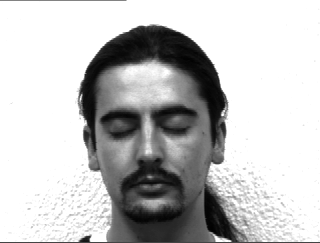

In [5]:
Image.open(path + '/data/yalefaces/subject09/subject09_sleepy.png')

### Prepare the database 

In [6]:
imPath = "data/yalefaces"
image_base_empty=[]
label_empty=[]

for i in range(1, 16):
    if i < 10:
        nb_subj = '0' + str(i)
    else:
        nb_subj = str(i)
    path_dir = 'subject' + nb_subj
    ls_path = glob(os.path.join(imPath + '/' + path_dir, '*' ))

    for file in ls_path: 
        im = np.array(Image.open(file))
        image_base_empty+=[im]
        label_empty+=[file.split('/')[2].split('_')[0].split('subject')[1]]   
    
image_base = np.array(image_base_empty)
labels = np.array(label_empty)

print("The shape of the labels is ", labels.shape)
print("The shape of the image_base is ", image_base.shape)
print("An image is represented as an array with the shape ", image_base[0].shape)

ramdom_seed=5
X_train, X_test, Y_train, Y_test = train_test_split(image_base, labels, test_size=0.20, random_state=ramdom_seed)

print("The sahpe of the train set is ", X_train.shape)
print("The sahpe of the test set is ", X_test.shape)

The shape of the labels is  (166,)
The shape of the image_base is  (166, 243, 320)
An image is represented as an array with the shape  (243, 320)
The sahpe of the train set is  (132, 243, 320)
The sahpe of the test set is  (34, 243, 320)


# Face recognition algorithm

## Introduction

Face recognition systems either perform face verification, i.e., classify a pair of pictures as belonging to the same individual or not, or perform face identification, i.e., put a label on an unknown face with respect to some training set. In this paper, we address the latter problem of face identification.

## SRC Algorithm

Wright et al. applied the ideas of sparse coding to face recognition: they proposed the Sparse Representation based Classification (SRC) scheme, a dictionary learning based approach to recognize faces. This method, which can be seen as an improvement over the previous ones, is far more robust and is able to handle occlusions and corruption of face images

In [7]:
# Algo SRC Solène 

The SRC algorithm led to other approaches, that use sparsity and improve the robustness in dealing with face alignment and pose variation issues.
Following the success of the use of sparsity in face recognition Zhang et al. questioned if sparsity was the key to the success of the SRC algorithm. They concluded that it is the use of collaborative representation (i.e., using an overcomplete dictionary) and not the sparsity constraint that improves face recognition performance. This led to the development of other algorithms like MSPCRC or PCRC that use this idea of collaborative representation.

In order to be robust, computationally efficient, and use minimal training, we choose to use the Robust Sparse Coding (RSC) algorithm with modifications, as presented in the [article](https://infoscience.epfl.ch/record/224338/files/1926.pdf). 

## RSC modified Algorithm

Bla-bla-bla theory

### Configuration of the algorithm

Config file containing some global variables and paths

In [8]:
PREDICTOR_PATH = path + "/shape_predictor_68_face_landmarks.dat"
CASCADE_PATH = path + "/haarcascade_frontalface_default.xml"

LEFT_EYE_POS = (6, 6)
EYES_SPACE = 18
FACE_HEIGHT = 32
EYE_MOUTH = 16
HEIGHT = 30
WIDTH = 30

IMREF_PATH = path + "/data/yalefaces/subject03/subject03_noglasses.png"
DATABASE_PATH = path + "data/yalefaces"
VERBOSE = False
LABELS = ["01", "02", "03", "04", "05", "06", "07", "08", "09", "10", "11", "12", "13", "14", "15"]

TRAINING_FACES = 4
TEST_FACES = 3
DIM_REDUCTION = False
NB_DIM = 15

NB_ITER = 2
PARAM_C = 8.0
PARAM_TAU = 0.8
LAMBDA = 0.001
REG_METHOD = 'l1' 

### Landmark algorithms

In [9]:
""" Create the landmarks of the argument image """

predictor = dlib.shape_predictor(PREDICTOR_PATH)
cascade = cv2.CascadeClassifier(CASCADE_PATH)


def convert_to_long(x, y, w, h):
    """ Put x, y, w, h to the good format """
    x = int(x)
    y = int(y)
    w = int(w)
    h = int(h)
    return x, y, w, h


def get_landmarks(img, detect_face=True):
    """ Return the landmarks of the image """
    w, h = img.shape[:2]

    x = 0.08 * w
    y = 0.08 * h
    w = 0.84 * w
    h = 0.84 * h
    x, y, w, h = convert_to_long(x, y, w, h)

    if detect_face:
        rects = cascade.detectMultiScale(img, 1.3, 5)
        if len(rects) >= 1:
            rects = rects[np.argsort(rects[:, 3])[::-1]]
            x, y, w, h = rects[0].astype(int)
            x = x.item()
            y = y.item()
            w = w.item()
            h = h.item()
    rect = dlib.rectangle(x, y, x + w, y + h)
    return np.array([(p.x, p.y) for p in predictor(img, rect).parts()])


def annotate_landmarks(im, landmarks):
    """ Draw blue points corresponding to the landmarks on the image """
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0], point[1])
        cv2.circle(im, pos, 3, color=(255, 0, 0))
        cv2.circle(im, pos, 2, color=(255, 0, 0))
        cv2.circle(im, pos, 1, color=(255, 0, 0))
        cv2.circle(im, pos, 0, color=(255, 0, 0))
    return im


def get_landmarks_image(image_path, save=False, image_path_to_save="./landmarks.png"):
    """ Show and return an image with the facial landmarks and optionally save it """
    im = np.array(Image.open(image_path).convert('RGB'))[:, :, ::-1]
    im = cv2.resize(im, None, fx=1.0, fy=1.0, interpolation=cv2.INTER_CUBIC)
    im_land = annotate_landmarks(im, get_landmarks(im))
    im_land = Image.fromarray(im_land)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    if save:
        cv2.imwrite(image_path_to_save, im_land)
    return im_land

### Face alignement algorithms 

In [10]:
"""
Functions performing face alignment (ie preprocessing tasks)
Face alignment is done in two parts: mesh align with triangulation and manual alignment
"""

predictor = dlib.shape_predictor(PREDICTOR_PATH)
cascade = cv2.CascadeClassifier(CASCADE_PATH)


def dist(tupleA, tupleB):
    """ Distance between two points in R^2 """
    return sqrt((tupleB[0] - tupleA[0]) ** 2 + (tupleB[1] - tupleA[1]) ** 2)


def detect_face(img):
    """ Function detecting the biggest face in an image """
    rects = cascade.detectMultiScale(img, 1.3, 5)
    rects = rects[np.argsort(rects[:, 3])[::-1]]
    x, y, w, h = rects[0]
    return img[y:y + h, x:x + w]


def useful_points_on_face(img, detect_face):
    """ Return the position of the nose, eyes and chin """
    lm = get_landmarks(img, detect_face)

    nose = lm[30]
    left_eye = tuple((np.array(lm[37]) + np.array(lm[38]) + np.array(lm[40]) + np.array(lm[41])) / 4.0)
    right_eye = tuple((np.array(lm[43]) + np.array(lm[44]) + np.array(lm[46]) + np.array(lm[47])) / 4.0)
    chin = lm[8]
    mideye = lm[27]
    # mouth
    mouth_array = np.zeros(2)
    for i in range(48, 68):
        mouth_array += np.array(lm[i])
    mouth = tuple(mouth_array / 20.0)

    return nose, chin, left_eye, right_eye, mideye, mouth


def rotate(img, angle, center):
    """ Rotate the image around center of angle """
    rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(img, rot_mat, (int(img.shape[1] * 1.0), int(img.shape[0] * 1.0)), flags=cv2.INTER_LINEAR)

    return result


def translation(img, vec):
    """ Translate the image according to the corresponding vector """
    tx = vec[0]
    ty = vec[1]
    M = np.float32([[1, 0, tx], [0, 1, ty]])
    return cv2.warpAffine(img, M, (img.shape[1], img.shape[0]))


def align(img, display=False, save=False):
    """ Manually align the image """
    nose, chin, left_eye, right_eye, mideye, mouth = useful_points_on_face(img, True)  # can try with False too

    eye_vector = np.array(right_eye) - np.array(left_eye)
    theta = atan2(eye_vector[1], eye_vector[0])
    img_rot = rotate(img, theta * 180.0 / pi, left_eye)
    eye_space = dist(left_eye, right_eye)
    face_height = dist(chin, mideye)
    x_factor = EYES_SPACE / eye_space
    y_factor = FACE_HEIGHT / face_height
    factor = (x_factor + y_factor) / 2.0
    img_res = cv2.resize(img_rot, None, fx=x_factor, fy=y_factor, interpolation=cv2.INTER_CUBIC)

    if display:
        cv2.imshow("First alignment", img_res)
        cv2.waitKey()
        cv2.destroyAllWindows()
    if save:
        cv2.imwrite("first_alignment.jpg", img_res)

    img = img_res
    left_eye = (left_eye[0] * x_factor, left_eye[1] * y_factor)
    transl_vec = tuple(np.array(LEFT_EYE_POS) - np.array(left_eye))
    img_t = translation(img, transl_vec)
    crop_img = img_t[0:HEIGHT, 0:WIDTH]
    img = crop_img

    if display:
        cv2.imshow("Manual Alignment", img)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    if save:
        cv2.imwrite("manual_alignment.jpg", img)

    return img


def preprocess_image_before_triangulation(img):
    """
    Perform preprocessing of the image
    Return all the points that will be used for the triangulation and the coordinates of the rectangle around the face
    """
    lm = get_landmarks(img, True) 
    x_img, y_img, _ = img.shape

    ymax = lm[8][1]
    xmin = lm[0][0]
    xmax = lm[16][0]
    ymin = min(lm[19][1], lm[24][1])
    xr = xmax - xmin
    yr = ymax - ymin
    epsilon = 0.08
    xmin_rect = int(xmin - epsilon * xr)
    xmax_rect = int(xmax + epsilon * xr)
    ymin_rect = int(ymin - epsilon * yr)
    ymax_rect = int(ymax + epsilon * yr)
    coord = (xmin_rect, xmax_rect, ymin_rect, ymax_rect)

    top_points = np.array([[x, ymin_rect] for x in np.linspace(xmin_rect, xmax_rect, 15)])
    bottom_points = np.array([[x, ymax_rect] for x in np.linspace(xmin_rect, xmax_rect, 20)])
    side_points = np.linspace(int(ymin_rect + yr * 1.1 / 12.0), int(ymax_rect - yr * 1.1 / 12.0), 11)
    left_points = np.array([[xmin_rect, y] for y in side_points])
    right_points = np.array([[xmax_rect, y] for y in side_points])

    lm_points = np.array([[x, y] for (x, y) in lm])
    all_points = np.concatenate((lm_points, top_points, right_points, bottom_points, left_points))

    all_points = np.array([
        [np.clip(x, 0, x_img - 1), np.clip(y, 0, y_img - 1)]
        for (x, y) in all_points
    ])

    return all_points, coord


def delaunay_triangulation(points, plot=False):
    """ Extract a Delaunay's triangulation from the points """
    tri = Delaunay(points)
    if plot:
        plt.triplot(points[:, 0], points[:, 1], tri.simplices.copy())
        plt.plot(points[:, 0], points[:, 1], 'o')
        plt.show()
    return tri.simplices


def warp_image(img, triangulation, base_points, coord):
    """
    Realize the mesh warping phase
    triangulation is the Delaunay triangulation of the base points
    base_points are the coordinates of the landmark poitns of the reference image
    code inspired from http://www.learnopencv.com/warp-one-triangle-to-another-using-opencv-c-python/
    """
    all_points, coordinates = preprocess_image_before_triangulation(img)
    img_out = 255 * np.ones(img.shape, dtype=img.dtype)
    for t in triangulation:
        src_tri = np.array([[all_points[x][0], all_points[x][1]] for x in t]).astype(np.float32)
        dest_tri = np.array([[base_points[x][0], base_points[x][1]] for x in t]).astype(np.float32)
        src_rect = cv2.boundingRect(np.array([src_tri]))
        dest_rect = cv2.boundingRect(np.array([dest_tri]))
        src_crop_tri = np.zeros((3, 2), dtype=np.float32)
        dest_crop_tri = np.zeros((3, 2))
        for k in range(0, 3):
            for dim in range(0, 2):
                src_crop_tri[k][dim] = src_tri[k][dim] - src_rect[dim]
                dest_crop_tri[k][dim] = dest_tri[k][dim] - dest_rect[dim]
        src_crop_img = img[src_rect[1]:src_rect[1] + src_rect[3], src_rect[0]:src_rect[0] + src_rect[2]]
        mat = cv2.getAffineTransform(np.float32(src_crop_tri), np.float32(dest_crop_tri))
        dest_crop_img = cv2.warpAffine(src_crop_img, mat, (dest_rect[2], dest_rect[3]), None,
            flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        mask = np.zeros((dest_rect[3], dest_rect[2], 3), dtype=np.float32)
        cv2.fillConvexPoly(mask, np.int32(dest_crop_tri), (1.0, 1.0, 1.0), 16, 0)
        dest_crop_img = dest_crop_img * mask
        img_out[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            img_out[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] * (
                (1.0, 1.0, 1.0) - mask)
        img_out[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] = \
            img_out[dest_rect[1]:dest_rect[1] + dest_rect[3], dest_rect[0]:dest_rect[0] + dest_rect[2]] + dest_crop_img

    return img_out[coord[2]:coord[3], coord[0]:coord[1]]


def mesh_align(img, imgref):
    """
    Maps all the triangles of the img image to the triangles of imgref
    """
    bp, coord = preprocess_image_before_triangulation(imgref)
    tr = delaunay_triangulation(bp)
    img_out = warp_image(img, tr, bp, coord)
    return img_out


def preprocess(img, imgref):
    """
    Align the image img with respect to the reference image imgref
    Does the two steps of mesh warping and manual alignment
    """
    im = mesh_align(img, imgref)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    im = align(im)
    return im


def draw_triangulation(im, tri, bp):
    """ Draw a triangulation """
    img = im.copy()
    for t in tri:
        n1 = t[0]
        n2 = t[1]
        n3 = t[2]
        pt1 = (int(bp[n1][0]), int(bp[n1][1]))
        pt2 = (int(bp[n2][0]), int(bp[n2][1]))
        pt3 = (int(bp[n3][0]), int(bp[n3][1]))
        cv2.line(img, pt1, pt2, (0, 0, 255))
        cv2.line(img, pt3, pt2, (0, 0, 255))
        cv2.line(img, pt1, pt3, (0, 0, 255))
    return img


def show_warped_image(im_path, save=False, save_path="warpedImage.jpg"):
    """ Show the result of the mesh warping process """
    img = np.array(Image.open(im_path).convert('RGB'))[:, :, ::-1]
    img_ref = np.array(Image.open(IMREF_PATH).convert('RGB'))[:, :, ::-1]
    img_warp = mesh_align(img, img_ref)
    cv2.imshow("warped image", img_warp)
    cv2.waitKey()
    cv2.destroyAllWindows()
    if save:
        cv2.imwrite(save_path, img_warp)


def show_aligned_image(im_path, save=False, save_path="alignedImage.jpg"):
    """ Show the result of the alignment process """
    img = np.array(Image.open(im_path).convert('RGB'))[:, :, ::-1]
    img_ref = np.array(Image.open(IMREF_PATH).convert('RGB'))[:, :, ::-1]
    img_aligned = preprocess(img, img_ref)
    cv2.imshow("aligned image", img_aligned)
    cv2.waitKey()
    cv2.destroyAllWindows()
    if save:
        cv2.imwrite(save_path, img_aligned)


def show_triangulation_image(im_path, save=False, save_path="triangulationImage.jpg"):
    """ Show the result of the alignment process """
    img = np.array(Image.open(im_path).convert('RGB'))[:, :, ::-1]
    img_ref = np.array(Image.open(IMREF_PATH).convert('RGB'))[:, :, ::-1]
    allpoints, co = preprocess_image_before_triangulation(img)
    bp, coord = preprocess_image_before_triangulation(img_ref)
    tr = delaunay_triangulation(bp)
    img_tri = draw_triangulation(img, tr, allpoints)
    cv2.imshow("triangulation image", img_tri)
    cv2.waitKey()
    cv2.destroyAllWindows()
    if save:
        cv2.imwrite(save_path, img_tri)

### Creation algorithms

In [11]:
""" Main functions to create the dictionaries """


def column_from_image(img, verbose=True):
    """ Create a column vector from input image """

    if verbose:
        print(img)
    imref = np.array(Image.open(IMREF_PATH).convert('RGB'))[:, :, ::-1]
    im = np.array(Image.open(img).convert('RGB'))[:, :, ::-1]
    im = preprocess(im, imref)
    rep = np.transpose(im).flatten()
    
    return rep


def create_dictionaries_from_db(repo, train_size, test_size, verbose=True):
    """ Create training and testing sets from a database with a fixed number of images in both sets """

    train_images = []
    test_images = []
    name_labels = {}
    directories = sorted(listdir(repo))
    label = 0
    #print("Processing images ...")
    for d in directories:
        images = sorted(listdir(repo + '/' + d))
        shuffle(images)
        if len(images) >= 10:  
            nb_img = 0
            i = 0
            while nb_img < train_size + test_size and i < len(images):
                path_image = repo + "/" + d + "/" + images[i]
                i += 1
                try:
                    if nb_img < train_size:
                        train_images.append(column_from_image(path_image, verbose))
                    else:
                        test_images.append(column_from_image(path_image, verbose))
                    nb_img += 1
                except (cv2.error, TypeError, ValueError) as e:
                    print("error image " + path_image + " " + str(e))
            if nb_img < train_size + test_size:
                print("Removing " + d)
                if nb_img <= train_size and nb_img > 0:
                    del train_images[-nb_img:]
                elif nb_img > 0:
                    del train_images[-train_size:]
                    del test_images[-(nb_img - train_size):]
            else:
                label += 1
                name_labels[label] = d

    train_set = (np.column_stack(train_images)).astype(float)
    test_set = (np.column_stack(test_images)).astype(float)

    print("Training and Test sets have been created with success!")
    print("There are " + str(label) + " classes")

    return train_set, test_set, label, name_labels

### Matrix algorithms

In [12]:
""" Utility functions operating on matrices """


def norm_column(col):
    """ Norm of a column vector """
    return lg.norm(col)


def normalize_column(col):
    """ Normalize a column vector """
    col = col.astype(float)
    sq = norm_column(col)
    ncol = col / sq
    return ncol


def normalize_matrix(matrix):
    """ Normalize a matrix """
    n, m = matrix.shape
    nmatrix = np.zeros((n, m))
    for j in range(m):
        nmatrix[:, j] = normalize_column(matrix[:, j])
    return nmatrix


def dim_reduct(matrix, reductor, enable_dim_reduction=False):
    """ Perform dimensionality reduction given a reductor matrix """
    if enable_dim_reduction:
        return reductor.transpose().dot(matrix)
    else:
        return matrix


def mean_sample(mat):
    """ Return the mean column of a matrix """
    n, m = mat.shape
    mean = np.array([sum(mat[i, :]) for i in range(n)]) / (1.0 * m)
    return mean

### PCA algorithm

In [13]:
def mean_row(matrix):
    """ Return the mean row of a matrix """
    matrix = matrix.astype(float)
    n, m = matrix.shape
    mean = np.zeros(n)
    for i in range(n):
        mean[i] = (sum(matrix[i, :])) / m
    return mean


def zeromean_row(matrix):
    """ Return a zero mean row matrix from the given matrix """
    n, m = matrix.shape
    meanR = mean_row(matrix)
    zmatrix = np.zeros((n, m))
    for i in range(n):
        zmatrix[i, :] = matrix[i, :] - meanR[i]
    return zmatrix


def biggest_eigen_k(matrix, K):
    """ Return the K eigenvector/eigenvalue pairs associated to the K greatest eigenvalues """
    eig_val, eig_vec = lg.eig(matrix)
    order = eig_val.argsort()[::-1]
    eig_val = eig_val[order]
    eig_vec = eig_vec[:, order]
    return eig_vec[:, :K], eig_val[:K]


def pca_reductor(Y, K):
    """
    Return the matrix W of the SVD
    To reduce the matrix M (p rows -> features, n columns -> test samples) we will only have to return W.transpose()*M
    """
    p, n = Y.shape
    Y = zeromean_row(Y)
    if p <= n:
        matrix = Y.dot(Y.transpose()) / (n - 1)
        eig_vec, eig_val = biggest_eigen_k(matrix, K)
        return eig_vec
    else:
        matrix = Y.transpose().dot(Y) / (n - 1)
        eig_vec, eig_val = biggest_eigen_k(matrix, K)
        eig_vec2 = np.zeros((p, K))
        Y = Y / sqrt(n - 1)
        for i in range(K):
            # print(eig_val[i])
            if eig_val[i] < 0:
                eig_val[i] = abs(eig_val[i])
            eig_vec2[:, i] = (1 / sqrt(eig_val[i])) * Y.dot(eig_vec[:, i])
        return eig_vec2

### RSC algorithm

In [14]:
"""
RSC modified algorithm according to the previously cited paper
"""


def f_delta(residual):
    """ Perform intermediate computation """
    n = len(residual)
    psi = residual ** 2
    psi = np.sort(psi)
    return psi[int(abs(PARAM_TAU * n))]


def classif(D, y, x, train_size, nb_classes):
    """ Perform classification of y using sparse encoding x """
    diff_tab = np.zeros(nb_classes)
    for c in range(nb_classes):
        xclass = x[train_size * c:train_size * (c + 1)]
        Dclass = D[:, train_size * c:train_size * (c + 1)]
        diff = y - Dclass.dot(xclass)
        diff_tab[c] = diff.dot(diff)
    return np.argmin(diff_tab) + 1


def to_diag(before_exp):
    """ Perform intermediate computation """
    n = len(before_exp)
    rep = np.zeros(n)
    for i in range(n):
        if before_exp[i] <= 700.0:
            rep[i] = 1.0 / (1.0 + exp(before_exp[i]))
        else:
            rep[i] = 0.0
        rep[i] = sqrt(rep[i])
    return rep


def l2_ls(D, y, lmbda):
    """ Analytically solve a l2-LASSO problem min ||x-Dy||^2 + lmbda ||x||^2"""
    pr = D.transpose().dot(D)
    n, n = pr.shape
    toinv = pr + lmbda * np.identity(n)
    inv = lg.inv(toinv)
    rest = D.transpose().dot(y)
    rep = inv.dot(rest)
    return rep


def RSC_identif(train_set, test_image, mean, reductor, dico_norm, nb_classes):
    """ Perform the identification of a test_image thanks to the adapted RSC algorithm """
    e = np.array((test_image - mean).astype(float))
    norm_y = norm_column(test_image)
    test_normalized = normalize_column(test_image)
    for j in range(NB_ITER):
        delta = f_delta(e)
        mu = PARAM_C / delta
        before_exp = mu * (e ** 2 - delta)
        todiag = to_diag(before_exp)

        w_train = normalize_matrix(train_set * todiag[:, np.newaxis])
        w_test = normalize_column(todiag * test_image)

        w_train_red = dim_reduct(w_train, reductor, DIM_REDUCTION)
        w_test_red = dim_reduct(w_test, reductor, DIM_REDUCTION)
        D = normalize_matrix(w_train_red)
        y = normalize_column(w_test_red)

        if REG_METHOD == 'l1':
            [x, status, hist] = L.l1ls(D, y, LAMBDA, quiet=True)
        else:
            x = l2_ls(D, y, LAMBDA)

        e = norm_y * (test_normalized - dico_norm.dot(x))

    return classif(D, y, x, TRAINING_FACES, nb_classes)

def test_recognizer(test_set):
    """ Perform the recognition task on the test_set and output accuracy """
    tot = 0
    good = 0
    y_true = []
    y_pred = []
    p, n = test_set.shape
    for i in range(n):
        y = test_set[:, i]
        trueClass = 1 + int(i / TEST_FACES)
        y_true.append(1.0*(trueClass))
        classif = RSC_identif(dico, y, mean, reductor, dico_norm, nb_classes)
        y_pred.append(1.0*(classif))
        #print("Class " + str(trueClass) + " identified as " + str(classif))
    cf_array = confusion_matrix(y_true, y_pred)
    acc = accuracy_score(y_true, y_pred)
    print("Accuracy score: ", acc)
    df_cm = pd.DataFrame(cf_array, range(1, 16), range(1, 16))
    # sn.set(font_scale=1.4)
    plt.figure(figsize = (10,10))
    sn.heatmap(df_cm, 
               annot=True, 
               #annot_kws={"size": 16}, 
               cmap = 'OrRd')
    plt.ylim(-0.5, 15.5)
    plt.xlim(-0.5, 15.5)
    plt.show()

### Launch the algorithm

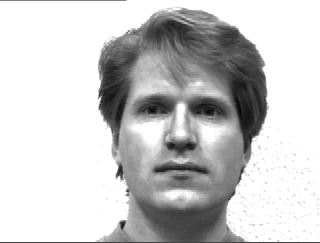

In [15]:
image_path = path + '/data/yalefaces/subject01/subject01_normal.png'
Image.open(image_path)

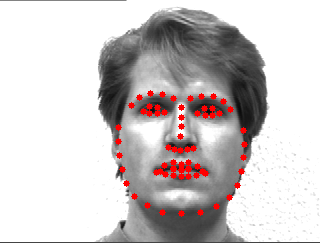

In [16]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject01/subject01_normal_landmarks.png')

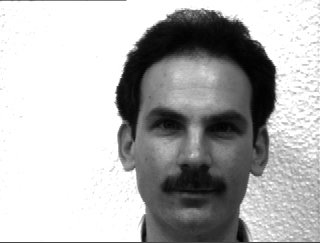

In [17]:
image_path = path + '/data/yalefaces/subject02/subject02_normal.png'
Image.open(image_path)

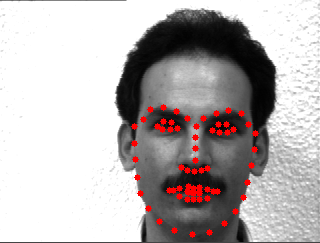

In [18]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject02/subject02_normal_landmarks.png')

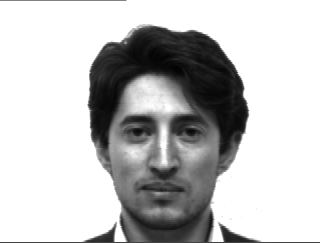

In [19]:
image_path = path + '/data/yalefaces/subject03/subject03_normal.png'
Image.open(image_path)

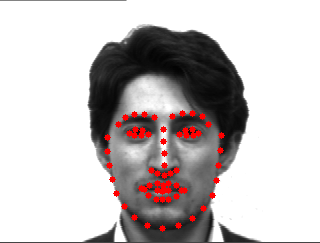

In [20]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject03/subject03_normal_landmarks.png')

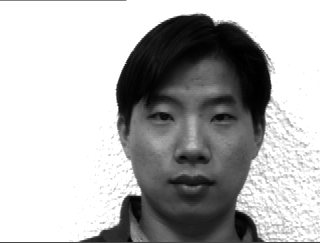

In [21]:
image_path = path + '/data/yalefaces/subject04/subject04_normal.png'
Image.open(image_path)

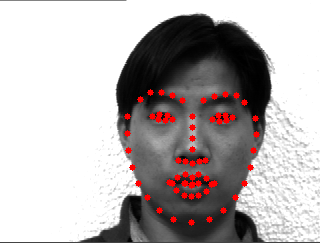

In [22]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject04/subject04_normal_landmarks.png')

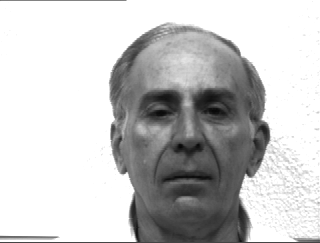

In [23]:
image_path = path + '/data/yalefaces/subject05/subject05_normal.png'
Image.open(image_path)

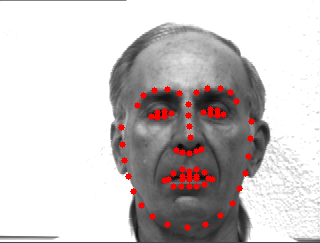

In [24]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject05/subject05_normal_landmarks.png')

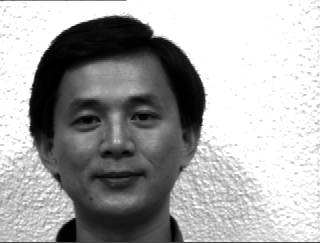

In [25]:
image_path = path + '/data/yalefaces/subject06/subject06_normal.png'
Image.open(image_path)

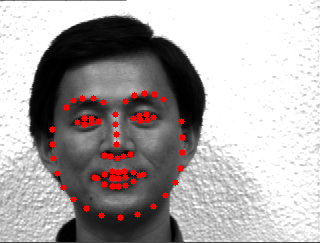

In [26]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject06/subject06_normal_landmarks.png')

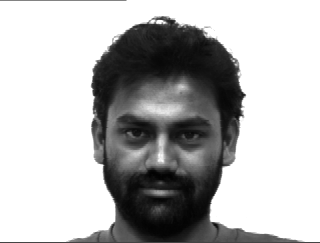

In [27]:
image_path = path + '/data/yalefaces/subject07/subject07_normal.png'
Image.open(image_path)

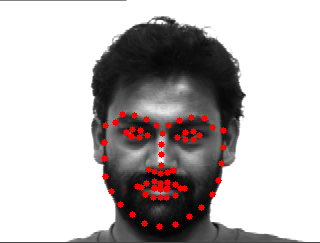

In [28]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject07/subject07_normal_landmarks.png')

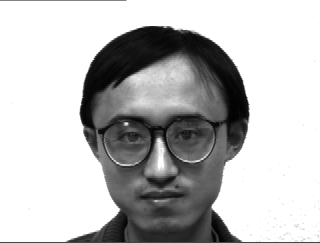

In [29]:
image_path = path + '/data/yalefaces/subject08/subject08_normal.png'
Image.open(image_path)

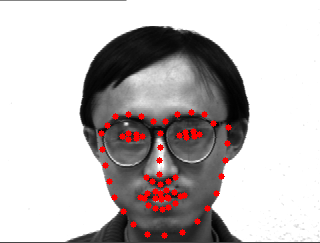

In [30]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject08/subject08_normal_landmarks.png')

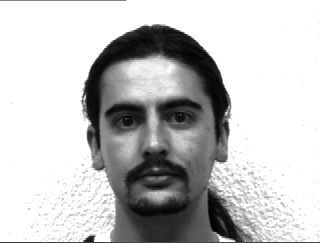

In [31]:
image_path = path + '/data/yalefaces/subject09/subject09_normal.png'
Image.open(image_path)

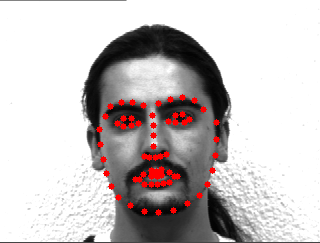

In [32]:
get_landmarks_image(image_path, False, path + '/data/yalefaces/subject09/subject09_sleepy_landmarks.png')

error image /Users/nbettache/Desktop/face_recognition/data/yalefaces/subject12/subject12_rightlight.png OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:2594: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'

error image /Users/nbettache/Desktop/face_recognition/data/yalefaces/subject12/subject12_surprised.png OpenCV(4.2.0) /Users/travis/build/skvark/opencv-python/opencv/modules/imgproc/src/imgwarp.cpp:2594: error: (-215:Assertion failed) src.cols > 0 && src.rows > 0 in function 'warpAffine'

Training and Test sets have been created with success!
There are 15 classes
Accuracy score:  0.7333333333333333


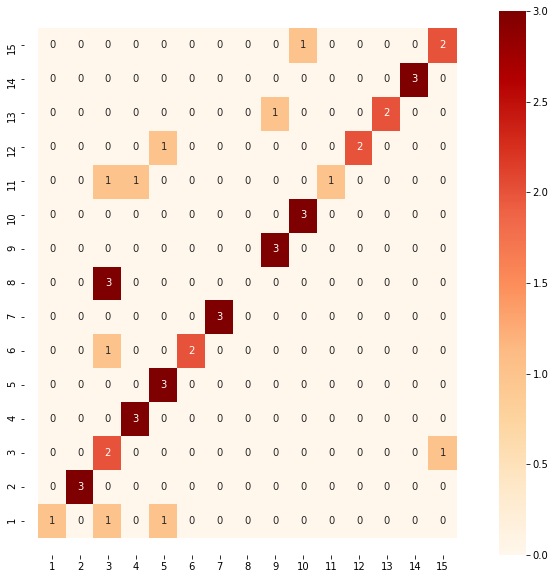

In [33]:
dico, test_set, nb_classes, name_labels = create_dictionaries_from_db(
        DATABASE_PATH, 
        TRAINING_FACES, 
        TEST_FACES, 
        VERBOSE)
reductor = pca_reductor(dico, NB_DIM)
mean = mean_sample(dico)
dico_norm = normalize_matrix(dico)
test_recognizer(test_set)